In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
import serbian_stemmer
from wordcloud import WordCloud

In [2]:
data = pd.read_excel('data/full_data.xlsx',sheet_name='Sheet1')

In [3]:
with open('serbian_stopwords.txt') as f:
    lines = f.readlines()
stopwords = []
for line in lines:
    stopwords.append(line[:-1])

Removing reviews without a grade:

In [4]:
missing = 100*(data[data.Rating == 0].shape[0])/(data.shape[0])
print('Percentage of reviews without a grade: %.2f' % missing + '%')
data = data[data.Rating > 0]

Percentage of reviews without a grade: 2.18%


Creating a label, every review with a total rating bellow 3.5 is considered negative:

In [5]:
data["Label"] = 0
data.loc[data.Rating >= 3.5,["Label"]] = 1
data[['Rating','Label']].describe().transpose().drop('count',axis=1)  

,mean,std,min,25%,50%,75%,max
Rating,4.444125,0.891965,1.0,4.3,4.8,5.0,5.0
Label,0.889035,0.314091,0.0,1.0,1.0,1.0,1.0


In [6]:
def replace_emoji(review):
    review = review.replace(";]", " ok ")
    review = review.replace(";-)", " ok ")
    review = review.replace(";)", " ok ")
            
    review = review.replace(":-))", " odlican ")
    review = review.replace("=3", " odlican ")
    review = review.replace(":]", " odlican ")
    review = review.replace("=]", " odlican ")
    review = review.replace(":3", " odlican ")
    review = review.replace("=)", " odlican ")
    review = review.replace(":)", " odlican ")
    review = review.replace(":-)", " odlican ")
            
    review = review.replace(":o", " iznenadjen ")
    review = review.replace("o.o", " iznenadjen ")
            
    review = review.replace(":(", " lose ")
    review = review.replace(":@", " lose ")
    review = review.replace(":-(", " lose ")
    review = review.replace(":-/", " lose ")
    review = review.replace(":/", " lose ")
            
    review = review.replace(":'(", " lose ")
            
    review = review.replace(":|", " neodlucan ")
    review = review.replace(":-|", " neodlucan ")
            
    review = review.replace(":*", " lepo ")
    review = review.replace(":-*", " lepo ")
            
    review = review.replace("+", " plus ")
    review = review.replace("-", " minus ")
    review = review.replace("!", " veoma ")
    return review

data['Title'] = data['Title'].apply(lambda x : replace_emoji(str(x)))
data['Content'] = data['Content'].apply(lambda x: replace_emoji(str(x)))

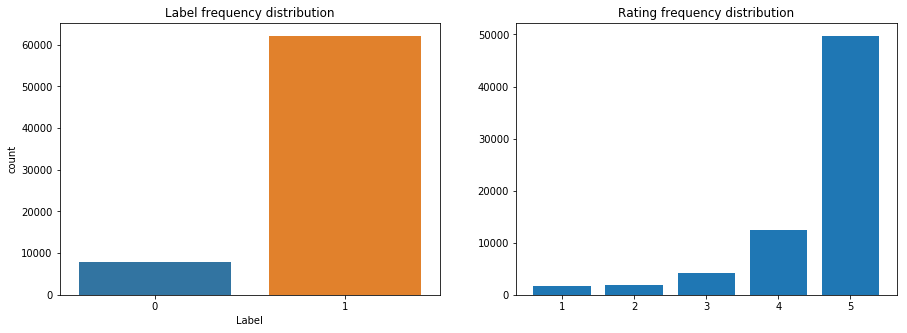

In [7]:
rating_distribution = { 1: data[data.Rating < 1.5].shape[0],
                        2: data[(data.Rating >= 1.5) & (data.Rating < 2.5)].shape[0],
                        3: data[(data.Rating >= 2.5) & (data.Rating < 3.5)].shape[0],
                        4: data[(data.Rating >=3.5) & (data.Rating < 4.5)].shape[0],
                        5: data[data.Rating >= 4.5].shape[0]
                      }
plt.figure(figsize=(15, 5))   
plt.subplot(121)
plt.title('Label frequency distribution')
sns.countplot(data.Label)
plt.subplot(122)
plt.bar(rating_distribution.keys(),rating_distribution.values())
plt.title('Rating frequency distribution')
plt.show()

As we can see vast majority of reviews has high score.

In [8]:
data["Title Character Count"] = data['Title'].str.len()
data["Review Character Count"] = data['Content'].str.len()
data[['Title Character Count','Review Character Count']].describe().transpose().drop('count',axis=1)

,mean,std,min,25%,50%,75%,max
Title Character Count,12.521745,9.168216,1.0,6.0,10.0,16.0,160.0
Review Character Count,94.546361,130.524555,1.0,20.0,51.0,116.0,2988.0


In [9]:
tokenizer = RegexpTokenizer(r'\w+')
data['Tokenized Title'] = data['Title'].apply(lambda x: tokenizer.tokenize(str(x)))
data['Tokenized Review'] = data['Content'].apply(lambda x: tokenizer.tokenize(str(x)))

data.dropna(subset=['Tokenized Title','Tokenized Review'],inplace=True)

data['Title Word Count'] = data['Tokenized Title'].apply(len)
data['Review Word Count'] = data['Tokenized Review'].apply(len)

In [10]:
data[['Title Word Count','Review Word Count']].describe().transpose().drop('count',axis=1)

,mean,std,min,25%,50%,75%,max
Title Word Count,2.054086,1.478038,0.0,1.0,2.0,3.0,24.0
Review Word Count,16.052797,22.655924,0.0,3.0,8.0,19.0,460.0


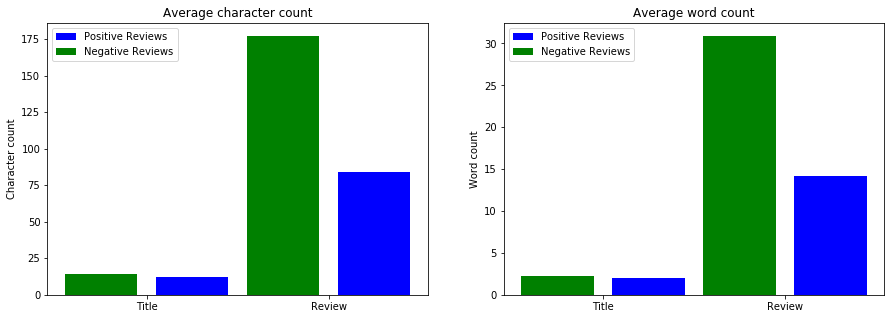

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
pos = [data[data['Label'] == 1]['Title Character Count'].mean(),data[data['Label'] == 1]['Review Character Count'].mean()]
neg = [data[data['Label'] == 0]['Title Character Count'].mean(),data[data['Label'] == 0]['Review Character Count'].mean()]
plt.bar([1,3], pos, color = 'b', label='Positive Reviews')
plt.bar([0,2], neg, color = 'g', label='Negative Reviews')
plt.xticks([0.5,2.5],['Title','Review'])
plt.title('Average character count')
plt.ylabel('Character count')
plt.legend()
plt.subplot(122)
pos = [data[data['Label'] == 1]['Title Word Count'].mean(),data[data['Label'] == 1]['Review Word Count'].mean()]
neg = [data[data['Label'] == 0]['Title Word Count'].mean(),data[data['Label'] == 0]['Review Word Count'].mean()]
plt.bar([1,3], pos, color = 'b', label='Positive Reviews')
plt.bar([0,2], neg, color = 'g', label='Negative Reviews')
plt.xticks([0.5,2.5],['Title','Review'])
plt.title('Average word count')
plt.ylabel('Word count')
plt.legend()
plt.show()


Negative reviews tend to be longer in both word and character count


<b>Preprocessing reviews includes:</b> 
+ converting all letters to lowercase 
+ removing stopwords 
+ stemming the words using serbian_stemmer

In [12]:
def preprocess(words):
    result = [w.lower() for w in words]
    result = [serbian_stemmer.stem(w) for w in result if w not in stopwords]
    return result

data['Processed Title'] = data['Tokenized Title'].apply(lambda x : preprocess(x)) 
data['Processed Review'] = data['Tokenized Review'].apply(lambda x : preprocess(x)) 

In [13]:
empty_reviews = data[np.logical_and(data['Processed Title'].apply(len) == 0,data['Processed Review'].apply(len) == 0)]
print('Number of empty reviews(both title and content of review) after removing stopwords: {}'.format(empty_reviews.shape[0]))
empty_reviews[['Title','Content','Label']]

Number of empty reviews(both title and content of review) after removing stopwords: 440


,Title,Content,Label
31,.,.,1
326,.,.,1
485,.,.,1
506,...,...,1
515,.,.,1
1118,.,.,1
1208,.,.,1
1323,.,.,1
1329,....,.....,1
1699,.,.,1


These reviews have no semantic value, therefor they will be removed from dataset:

In [14]:
data = data[np.logical_or(data['Processed Title'].apply(len) > 0,data['Processed Review'].apply(len) > 0)]

In [15]:
data[['Title','Content','Processed Title','Processed Review']].head()

,Title,Content,Processed Title,Processed Review
0,odlicne pice,Odrzavaju odlican kvalitet.,"[odlicn , pic ]","[odrzava , odlican , kvalitet ]"
1,Rostilj,kvalitetno i brzo,[rostilj ],"[kvalitetn , brz ]"
2,Spek pica,Fenomenalna kombinacija za ljubitelje jakih uk...,"[spek , pic ]","[fenomenaln , kombinacij , ljubitelj , jak , u..."
3,super su,za prvi put sve ok veoma,[super ],[ok ]
4,super,super su,[super ],[super ]


In [16]:
print('Number of empty reviews with positive label:',empty_reviews[empty_reviews['Label'] == 1].shape[0])
print('Number of empty reviews with negative label:',empty_reviews[empty_reviews['Label'] == 0].shape[0])

Number of empty reviews with positive label: 408
Number of empty reviews with negative label: 32


In [29]:
empty_reviews[empty_reviews['Label']==0]

,User,Title,Content,Rating,Published,Food Quality,Food Choice,Prices,Service,Label,Title Character Count,Review Character Count,Tokenized Title,Tokenized Review,Title Word Count,Review Word Count,Processed Title,Processed Review
4291,Deki1995,.,.,2.5,2017-01-27,3.0,3.0,3.0,1.0,0,1,1,[],[],0,0,[],[]
4645,VojkanD4,ja,ja,3.3,2019-02-24,5.0,3.0,2.0,3.0,0,2,2,[ja],[ja],1,1,[],[]
4732,ValentinaM17,.,.,2.8,2019-02-05,2.0,4.0,1.0,4.0,0,1,1,[],[],0,0,[],[]
4784,nellov,...,...,2.8,2019-01-18,3.0,3.0,2.0,3.0,0,3,3,[],[],0,0,[],[]
5569,Zeljko28,/,/,2.5,2019-02-06,2.0,4.0,3.0,1.0,0,1,1,[],[],0,0,[],[]
8664,Vojo2,A,A,3.0,2017-07-01,2.0,2.0,5.0,3.0,0,1,1,[A],[A],1,1,[],[]
19521,avenidaquinta,.,.,3.0,2019-01-19,3.0,3.0,3.0,3.0,0,1,1,[],[],0,0,[],[]
21328,sanja1404,*,*,3.3,2018-11-12,4.0,4.0,4.0,1.0,0,1,1,[],[],0,0,[],[]
22916,nemanjap9,.,.,3.3,2018-12-27,4.0,4.0,3.0,2.0,0,1,1,[],[],0,0,[],[]
25935,Алекса,.,.,3.0,2018-11-13,4.0,4.0,3.0,1.0,0,1,1,[],[],0,0,[],[]


As we can see majority of reviews without a content after preprocessing have positive label. Even the ones with negative label are somewhat close to being positive.

Next, 2 datasets will be created by merging title and content of review, one using upweighting(counting the words from the title twice, assuming that title contains more semantic value), and second without upweighting.

In [18]:
final_upweighting = pd.DataFrame()
final = pd.DataFrame()
final_upweighting['Review'] = (data['Processed Title'] + data['Processed Title'] + data['Processed Review']).apply(lambda x: ''.join(x))
final_upweighting['Label'] = data['Label']
final['Review'] = (data['Processed Title'] + data['Processed Review']).apply(lambda x: ''.join(x))
final['Label'] = data['Label']

In [19]:
final.head()

,Review,Label
0,odlicn pic odrzava odlican kvalitet,1
1,rostilj kvalitetn brz,1
2,spek pic fenomenaln kombinacij ljubitelj jak u...,1
3,super ok,1
4,super super,1


In [20]:
final_upweighting.head()

,Review,Label
0,odlicn pic odlicn pic odrzava odlican kvalitet,1
1,rostilj rostilj kvalitetn brz,1
2,spek pic spek pic fenomenaln kombinacij ljubit...,1
3,super super ok,1
4,super super super,1


In [21]:
final_upweighting.to_csv('final_upweigting.csv')
final.to_csv('final.csv')

Wordcloud for all reviews


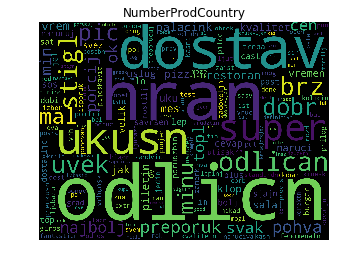

Wordcloud for positive reviews


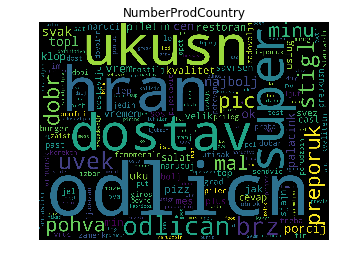

Wordcloud for negative reviews


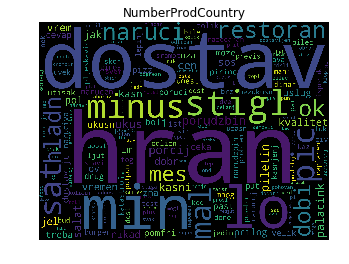

In [23]:
def wordcloud(text):
    wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=2000, height=1500).generate(text)
    plt.imshow(wordcloud)
    plt.title('NumberProdCountry')
    plt.axis("off")
    plt.show()
all_txt = ''.join(final['Review'])
pos_txt = ''.join(final[final['Label']==1]['Review'])
neg_txt = ''.join(final[final['Label']==0]['Review'])
print('Wordcloud for all reviews')
wordcloud(all_txt)
print('Wordcloud for positive reviews')
wordcloud(pos_txt)
print('Wordcloud for negative reviews')
wordcloud(neg_txt)

In [24]:
mrs = pd.read_csv('final.csv')

In [25]:
missing = data.iloc[mrs[mrs['Review'].isnull()].index.tolist()]